In [1]:
%load_ext autoreload
%autoreload 2

In [14]:
import numpy as np
import sys

sys.path.insert(0, '/home/storage/hans/jax_reco/python')
from network import TriplePandleNet
from trafos import transform_network_outputs, transform_dimensions
from plotting_tools import adjust_plot_1d
import matplotlib.pyplot as plt

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
import jax.numpy as jnp
import jax

from jax import config
config.update("jax_enable_x64", True)

In [15]:
net = TriplePandleNet('../../data/network/')

In [62]:
dist = 12.0
z = -210.0
rho = 0.0
zenith = np.pi/2
azimuth = 0.0

x = transform_dimensions(dist, rho, z, zenith, azimuth)

In [63]:
# apply network and transform output
y_pred = net.eval(x)
logits, a, b = transform_network_outputs(y_pred)

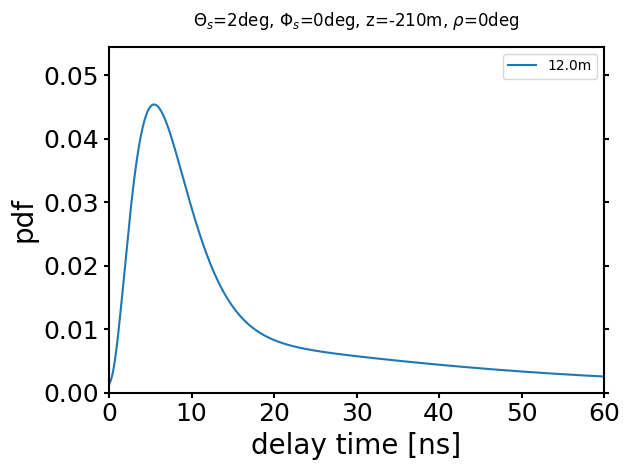

In [64]:
# create a batch of mixture distributions
gm = tfd.MixtureSameFamily(
          mixture_distribution=tfd.Categorical(
              logits=logits
              ),
          components_distribution=tfd.Gamma(
            concentration=a,    
            rate=b,
            force_probs_to_zero_outside_support=True
              )
    )

xvals = np.linspace(-10, 100, 1000)
yvals = gm.prob(xvals)

fig, ax = plt.subplots()
plt.plot(xvals, yvals, label=f'{dist:.1f}m')

plot_args = {'xlim':[0, 60],
                 'ylim':[0.0, 1.2 * np.amax(yvals)],
                 'xlabel':'delay time [ns]',
                 'ylabel':'pdf'}

adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.title(f"$\\Theta_s$={zenith:.0f}deg, $\\Phi_s$={azimuth:.0f}deg, z={z:.0f}m, $\\rho$={rho:.0f}deg", pad=15)
plt.tight_layout()
plt.show()

In [65]:
@jax.jit
def triple_pandel_mpe(dist, z, rho, zenith, azimuth, xvals, n_photons):
    # transform network inputs
    x = transform_dimensions(dist, rho, z, zenith, azimuth)
    # apply network and transform output
    y_pred = net.eval(x)
    logits, a, b = transform_network_outputs(y_pred)
    
    gm = tfd.MixtureSameFamily(
          mixture_distribution=tfd.Categorical(
              logits=logits
              ),
          components_distribution=tfd.Gamma(
            concentration=a,    
            rate=b,
            force_probs_to_zero_outside_support=True
              )
    )

    return n_photons * gm.prob(xvals) * (1-gm.cdf(xvals))**(n_photons-1)

triple_pandel_mpe_v = jax.jit(jax.vmap(triple_pandel_mpe, (None, None, None, None, None, None, 0), 0))


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


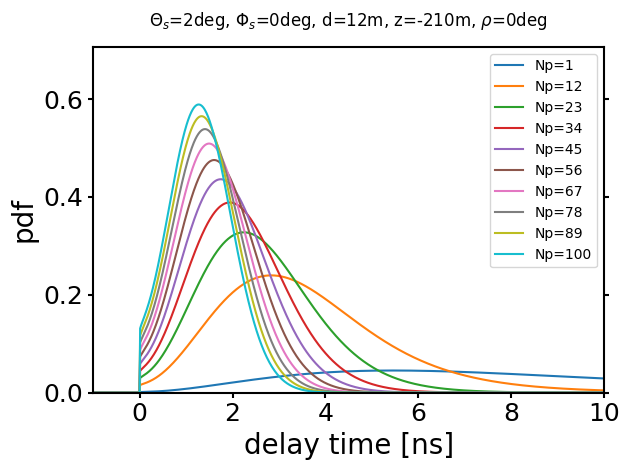

In [66]:
xvals = np.linspace(-10, 100, 10000)

n_photons = jnp.array(np.linspace(1, 100, 10))
yvals = triple_pandel_mpe_v(dist, z, rho, zenith, azimuth, xvals, n_photons)

fig, ax = plt.subplots()
xvals = np.repeat(xvals[np.newaxis,:], 10, axis=0)
plt.plot(xvals.T, yvals.T)

plot_args = {'xlim':[-1, 10],
                 'ylim':[0.0, 1.2 * np.amax(yvals)],
                 'xlabel':'delay time [ns]',
                 'ylabel':'pdf'}

adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.legend([f'Np={n:.0f}' for n in n_photons])
plt.title(f"$\\Theta_s$={zenith:.0f}deg, $\\Phi_s$={azimuth:.0f}deg, d={dist:.0f}m, z={z:.0f}m, $\\rho$={rho:.0f}deg", pad=15)
plt.tight_layout()
plt.show()

In [78]:
jax.value_and_grad(triple_pandel_mpe, argnums=[0,1,2,3,4,5])(dist, z, rho, zenith, azimuth, 2.0, 32.0)

(Array(0.37876897, dtype=float64),
 (Array(-0.06050026, dtype=float64, weak_type=True),
  Array(0.00240684, dtype=float64, weak_type=True),
  Array(0.00337147, dtype=float64, weak_type=True),
  Array(-7.01182142e-05, dtype=float64, weak_type=True),
  Array(6.21312179e-05, dtype=float64, weak_type=True),
  Array(-0.00479018, dtype=float64, weak_type=True)))

In [80]:
# check normalization
step = 1.e-3
bins = np.linspace(0, 10, 1001)
centers = 0.5*(bins[:-1]+bins[1:])
yvals = triple_pandel_mpe(dist, z, rho, zenith, azimuth, centers, 30.0)

In [81]:
print(jnp.sum(yvals) * (bins[1]-bins[0]))
# 0.9999929106264627 -> unity! ;-)

0.9999929106264627
